# 1. Intro

**FAQ style retrieval based chat bot**
- Train three model types (in different configurations) to figure out user input and map to a response class. Let's see which one does well. The models are
    - a TF-IDF similarity measure doc classifier 
    - a TFIDF based n-gram MLP multi-class classifier (supervised)
    - an RNN classifier (unsupervised)

**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


# 2. Corana Dashboard by John Hopkins Uni

[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [1]:
### John Hopkins Dashboard - https://coronavirus.jhu.edu/map.html
from IPython.display import IFrame
## default 77.3846,11.535 
start_coordz = "77.3846,11.535"  # rabat, morocco"33.9693414,-6.9273026"
center_coordz = "28.8189834,-2.5117154" #center Bukavu, DRC "-2.5117154,28.8189834"

IFrame(src="//arcgis.com/apps/Embed/index.html?webmap=14aa9e5660cf42b5b4b546dec6ceec7c&extent="+start_coordz+",163.5174,52.8632"+
       "&center="+center_coordz+
       "&zoom=true&previewImage=false&scale=true&disable_scroll=true&theme=light", 
    width="650", height="400", frameborder="0", scrolling="no", marginheight="0", marginwidth="0", title="2019-nCoV" )

# 3. FAQ Chat bot - Part 3

- Final model 
- Test interaction

## 3.1. Load Data

In [2]:
import numpy as np
import pandas as pd

import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../../../shared") 
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet


import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').disabled = True
# logging.getLogger('google_auth_oauthlib').disabled = True

In [4]:
## plot settings
params = {
    'font.size' : 14.0,
    'figure.figsize': (20.0, 12.0),
    'figure.dpi' : 40
}
plt.rcParams.update(params)
plt.style.use('fivethirtyeight') #tableau-colorblind10 ggplot

In [5]:
#### Helpers
headline_counter = 1
def printHeadline(src, msg):
    global headline_counter
    print( "\n{0} {1}. {2} : {3} {0}".format("-"*6, headline_counter, str(src).upper(), msg))
    headline_counter += 1

In [6]:
#### shared varz

## 1. baseline = use text as is and uni-gram
clean_paramz = {    
    'remove_stopwordz' : False,
    'stop_wordz' : None, #use default english 
    'remove_numberz' : False, 
    'lemmatized' : False, 
    'unique' : False
}

ngramz = (1,1)

## 2. TODO: train_test_split. For now use below
val_txt = ['Is corana deadly', 
           'What is corana', 
           "Should my pet get tested", 
           "Will mosquito bite infect me", 
          "Can I visit my elderly parents", 
          "Is there a vaccine"]

val_ylabz = ['covid19_define',
             'covid19_define',
            'pets_infection', 
            'covid19_spread_insects',
            'covid19_at_risk',
            'covid19_cure']


# 3.2. Baseline

In [7]:
headline_counter = 1

### Load from GSheet
printHeadline('Load', 'Fetching data from Gsheet')

faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ
dset = ZGsheetFaqDataSet()
dset.initFromResource(faq_path, faq_typ)  

print("Example Featurez.Original:\n {}".format( dset.data[:3] ) )


------ 1. LOAD : Fetching data from Gsheet ------
Example Featurez.Original:
 ['what is a pandemic?' 'what causes pandemics?'
 'what does it mean that WHO has declared a pandemic?']


In [8]:
printHeadline('Load', 'Preprocess data to clean')
dset.preprocess( **clean_paramz)

print("Example Featurez.Cleaned: {}".format( dset.clean_data[:3] ) )
print("Example Label: {}".format( dset.y_labelz[:3] ) )

print("Example Featurez.Cleaned: {}".format( dset.clean_data[-1:] ) )
print("Example Label: {}".format( dset.y_labelz[-1:] ) )


------ 2. LOAD : Preprocess data to clean ------
Example Featurez.Cleaned: ['what is a pandemic' 'what causes pandemics'
 'what does it mean that who has declared a pandemic']
Example Label: ['pandemic_define' 'pandemic_define' 'pandemic_define']
Example Featurez.Cleaned: ['how can i help or contribute to government activities']
Example Label: ['help_axn']


In [9]:
## TFIDF encode 
encoder_tfidf, encoded_featurez = dset.encodeTrain(enc_type=zdataset.ZENC_TFIDF, ngramz=ngramz ) 
print("Example Encoding: {}".format( encoded_featurez[-1:] ) ) 

Example Encoding:   (0, 4)	0.4571085363068012
  (0, 107)	0.4571085363068012
  (0, 59)	0.4571085363068012
  (0, 120)	0.3965741370024213
  (0, 38)	0.2071448693182601
  (0, 194)	0.25175663886910676
  (0, 290)	0.25175663886910676
  (0, 127)	0.21497093908928158


In [10]:

val_ylabz_int = dset.ylabelzAsInts(val_ylabz)


# 4.1 Cosine Similarity Model @ Baseline

In [11]:
### Helpers
plot_valz = []

def validateCosineModel(i=1, log=True):
    if log:
        print("\n{0} {1}. PREPROCESSING @ Validation Data {0}".format("-"*6, i))
    cleaned_txt = dset.preprocessPredict( val_txt)
    
    if log:
        for itx, otx in zip(val_txt, cleaned_txt):
            print("CLEANED: {} ===> {}".format(itx, otx))
        
    
    if log:
        print("\n{0} {1}. PREDICT @ Validation Data {0}".format("-"*6, i+1 ))
    acc, predicted_yz = model.validate( cleaned_txt, val_ylabz_int)
    
    for idx, txt, y in  zip( predicted_yz, val_txt, val_ylabz):
        cat,resp =  dset.getPredictedAtIndex( idx )
        if log:
            print("PREDICTED: {}:{} ===> {} for '{}' ".format(idx, y, cat, txt))
    #     print("\t{}\n".format(resp) )
    
    if log:
        print(">>> Predicted Accuracy: {} \n{}".format( acc, predicted_yz) ) 
    return acc
    
    
def resetData(paramz, ngramz, log=True): 
    if log:
        print("\n{0} 1. PREPROCESSING @ Training Data {0}".format("-"*6))
    dset.preprocess(**paramz) 
    dlen = len( dset.clean_data )
    eg_idx = [0, 1,  dlen-1, dlen-2]    
    
    if log:
        for eg in eg_idx:
            print("{} ===> {} == {}".format( dset.data[eg], dset.clean_data[eg], dset.y_labelz[eg]) )    
    
    if log:
        print("\n{0} 2. TFIDF ENCODE AND BUILD MODEL @ Validation Data {0}".format("-"*6))
    dset.encodeTrain(ngramz=ngramz)
    model.build( 
        dset.context , 
        dset.encoded_matrix, 
        dset.ylabelzAsInts(), 
        dset.preprocessor )
    if log:
        print("TFIDF: {}".format( dset.context))

    
def resetCosineModel(paramz, ngramz, log=True):    
    resetData( paramz, ngramz , log) 
    return validateCosineModel(3, log)
    

In [12]:
from zmodel_cosine_similarity import ZCosineSimilarity

In [13]:
## setup 
model = ZCosineSimilarity('TFIDF_Cosine')
model.build( dset.context , dset.encoded_matrix, 
            dset.ylabelzAsInts(), dset.preprocessor)

In [14]:
## Run for baseline 
base_acc = validateCosineModel()

INFOR   : 2020-04-08 20:58:00.112895 [cosine.predict] IN: ['is corana deadly']
INFOR   : 2020-04-08 20:58:00.113892 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:00.113892 [cosine.predict] IN.CLEAN: ['is', 'corana', 'deadly']
INFOR   : 2020-04-08 20:58:00.115888 [cosine.predict] IN: ['what is corana']
INFOR   : 2020-04-08 20:58:00.115888 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:00.116924 [cosine.predict] IN.CLEAN: ['what', 'is', 'corana']
INFOR   : 2020-04-08 20:58:00.117910 [cosine.predict] IN: ['should my pet get tested']
INFOR   : 2020-04-08 20:58:00.118880 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lem


------ 1. PREPROCESSING @ Validation Data ------
CLEANED: Is corana deadly ===> is corana deadly
CLEANED: What is corana ===> what is corana
CLEANED: Should my pet get tested ===> should my pet get tested
CLEANED: Will mosquito bite infect me ===> will mosquito bite infect me
CLEANED: Can I visit my elderly parents ===> can i visit my elderly parents
CLEANED: Is there a vaccine ===> is there a vaccine

------ 2. PREDICT @ Validation Data ------
PREDICTED: 45:covid19_define ===> covid19_facemasks for 'Is corana deadly' 
PREDICTED: 45:covid19_define ===> covid19_facemasks for 'What is corana' 
PREDICTED: 26:pets_infection ===> covid19_contact_infected for 'Should my pet get tested' 
PREDICTED: 38:covid19_spread_insects ===> covid19_testing for 'Will mosquito bite infect me' 
PREDICTED: 51:covid19_at_risk ===> covid19_travel for 'Can I visit my elderly parents' 
PREDICTED: 45:covid19_cure ===> covid19_facemasks for 'Is there a vaccine' 
>>> Predicted Accuracy: 0.3333333333333333 
[45 45 

## 4.2. Fine Tuning Cosine Similarity Model

In [15]:
### 1. clean up text and uni-gram 
lemmatized_paramz = {
        'remove_stopwordz' : True,
        'stop_wordz' : None, #use default english 
        'remove_numberz' : True, 
        'lemmatized' : True, 
        'unique' : False    }

stopzIn_paramz = {
        'remove_stopwordz' : False,
        'stop_wordz' : None, #use default english 
        'remove_numberz' : True, 
        'lemmatized' : True, 
        'unique' : False    }

def getParamz(tname):
    if tname.startswith('lemmaz'):
        return lemmatized_paramz
    elif tname.startswith('stopz'):
        return stopzIn_paramz
    else:
        return clean_paramz
    
def plotAcc(x_srcz, y_valz, huez, ttitle='Cosine Similarity'):
    g = sns.barplot( x=x_srcz, y=y_valz, hue=huez, dodge=False)
    g.set_title("Accuracy @ {} {} Cofigz".format(len(x_srcz), ttitle))
    g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.legend(loc='upper right')
    plt.show()
    
tnamez = ['lemmaz_uni', 'stopz_uni', 
          'base_bi', 'base_tri', 'base_uni-bi', 'base_uni-tri', 'base_bi-tri',
          'lemmaz_bi', 'lemmaz_tri', 'lemmaz_uni-bi', 'lemmaz_uni-tri', 'lemmaz_bi-tri',
          'stopz_bi', 'stopz_tri', 'stopz_uni-bi', 'stopz_uni-tri', 'stopz_bi-tri'
         ]
tgramz = [(1,1), (1,1), 
          (2,2), (3,3), (1,2), (1,3), (2,3),
          (2,2), (3,3), (1,2), (1,3), (2,3),
          (2,2), (3,3), (1,2), (1,3), (2,3)]



In [16]:
def runFineTuneCosineHyperz(tnamez=tnamez, tgramz=tgramz, base_acc = base_acc):
    run_modez = {'base_uni' : base_acc}
    printHeadline('TUNE', 'Cheking different n-gram and cleaning combinations')
    for tryz, tgram in zip(tnamez, tgramz):
        argzd = getParamz(tryz)
        acc = resetCosineModel( argzd, tgram, log=False)
        run_modez[tryz] = acc 
        
    printHeadline('TUNE.RESULTS', "Tabulate Results ")
    for k, g in run_modez.items():
        print("{} \t\tacc = {}".format(k, g) ) 
    print("\n{0}\nKEY:{1}{2} {1}{3} {1}{4} {1}{5}".format( "-"*12, "\n\t>>", 
            "base = keep text as is",
            "lemmaz = remove stop words, numbers and lemmatize", 
            "stopz = keep stop words but remove numbers and lemmatize", 
            "uni, bi, tri = unigram, bigram, trigram respectively.\n\t And so is the range E.g. uni-tri = (1,3)") )
    
    printHeadline('TUNE.RESULTS', "Plot Results ")
    sorted_keyz = list(run_modez.keys() )
    sorted_keyz.sort() 
    sorted_valuez = [ run_modez[k] for k in sorted_keyz ] 
    plotAcc(sorted_keyz, sorted_valuez, [x.split('_')[0] for x in sorted_keyz ] )
    


------ 3. TUNE : Cheking different n-gram and cleaning combinations ------


INFOR   : 2020-04-08 20:58:01.299749 [cosine.predict] IN: ['corana deadly']
INFOR   : 2020-04-08 20:58:01.299749 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.300733 [cosine.predict] IN.CLEAN: ['corana', 'deadly']
INFOR   : 2020-04-08 20:58:01.302713 [cosine.predict] IN: ['corana']
INFOR   : 2020-04-08 20:58:01.302713 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.303714 [cosine.predict] IN.CLEAN: ['corana']
INFOR   : 2020-04-08 20:58:01.304722 [cosine.predict] IN: ['pet get tested']
INFOR   : 2020-04-08 20:58:01.305705 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-

INFOR   : 2020-04-08 20:58:01.407434 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.408459 [cosine.predict] IN.CLEAN: ['should', 'my', 'pet', 'get', 'tested']
INFOR   : 2020-04-08 20:58:01.409428 [cosine.predict] IN: ['will mosquito bite infect me']
INFOR   : 2020-04-08 20:58:01.410426 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.410426 [cosine.predict] IN.CLEAN: ['will', 'mosquito', 'bite', 'infect', 'me']
INFOR   : 2020-04-08 20:58:01.411423 [cosine.predict] IN: ['can i visit my elderly parents']
INFOR   : 2020-04-08 20:58:01.412420 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique'

INFOR   : 2020-04-08 20:58:01.505172 [cosine.predict] IN: ['can i visit my elderly parents']
INFOR   : 2020-04-08 20:58:01.505172 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.506169 [cosine.predict] IN.CLEAN: ['can', 'i', 'visit', 'my', 'elderly', 'parents']
INFOR   : 2020-04-08 20:58:01.508164 [cosine.predict] IN: ['is there a vaccine']
INFOR   : 2020-04-08 20:58:01.508164 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': False, 'lemmatized': False, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.509161 [cosine.predict] IN.CLEAN: ['is', 'there', 'a', 'vaccine']
INFOR   : 2020-04-08 20:58:01.584992 [cosine.predict] IN: ['corana deadly']
INFOR   : 2020-04-08 20:58:01.585957 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz':

INFOR   : 2020-04-08 20:58:01.858256 [cosine.predict] IN: ['corana']
INFOR   : 2020-04-08 20:58:01.858256 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.859226 [cosine.predict] IN.CLEAN: ['corana']
INFOR   : 2020-04-08 20:58:01.860224 [cosine.predict] IN: ['pet get tested']
INFOR   : 2020-04-08 20:58:01.861221 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:01.861221 [cosine.predict] IN.CLEAN: ['pet', 'get', 'tested']
INFOR   : 2020-04-08 20:58:01.863230 [cosine.predict] IN: ['mosquito bite infect']
INFOR   : 2020-04-08 20:58:01.863230 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': True, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFO

INFOR   : 2020-04-08 20:58:02.049745 [cosine.predict] IN.CLEAN: ['will', 'mosquito', 'bite', 'infect', 'me']
INFOR   : 2020-04-08 20:58:02.050714 [cosine.predict] IN: ['can i visit my elderly parent']
INFOR   : 2020-04-08 20:58:02.051739 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:02.051739 [cosine.predict] IN.CLEAN: ['can', 'i', 'visit', 'my', 'elderly', 'parent']
INFOR   : 2020-04-08 20:58:02.053706 [cosine.predict] IN: ['is there a vaccine']
INFOR   : 2020-04-08 20:58:02.053706 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:02.053706 [cosine.predict] IN.CLEAN: ['is', 'there', 'a', 'vaccine']
INFOR   : 2020-04-08 20:58:02.088640 [cosine.predict] IN: ['is corana deadly']
INFOR   : 2020-04-08 20:58

INFOR   : 2020-04-08 20:58:02.198319 [cosine.predict] IN.CLEAN: ['is', 'there', 'a', 'vaccine']
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.16.
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
findfont: score(<Font

findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Calibri' (calibri.ttf) normal nor

findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) i

findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT'


------ 4. TUNE.RESULTS : Tabulate Results  ------
base_uni 		acc = 0.3333333333333333
lemmaz_uni 		acc = 0.5
stopz_uni 		acc = 0.3333333333333333
base_bi 		acc = 0.0
base_tri 		acc = 0.0
base_uni-bi 		acc = 0.3333333333333333
base_uni-tri 		acc = 0.0
base_bi-tri 		acc = 0.0
lemmaz_bi 		acc = 0.0
lemmaz_tri 		acc = 0.0
lemmaz_uni-bi 		acc = 0.5
lemmaz_uni-tri 		acc = 0.5
lemmaz_bi-tri 		acc = 0.0
stopz_bi 		acc = 0.0
stopz_tri 		acc = 0.0
stopz_uni-bi 		acc = 0.3333333333333333
stopz_uni-tri 		acc = 0.0
stopz_bi-tri 		acc = 0.0

------------
KEY:
	>>base = keep text as is 
	>>lemmaz = remove stop words, numbers and lemmatize 
	>>stopz = keep stop words but remove numbers and lemmatize 
	>>uni, bi, tri = unigram, bigram, trigram respectively.
	 And so is the range E.g. uni-tri = (1,3)

------ 5. TUNE.RESULTS : Plot Results  ------


findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Fax' (LFAXD.TTF) normal normal demibold normal>) = 10.24
findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal bol

findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: 

findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
findfont: score(<Font 'Tw Cen MT

findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 11.335
findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal demi normal>) = 10.24
findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal black normal>) = 11.525
findfont: score(<Font 'Arial' (arialbi.ttf) italic normal bold normal>) = 7.698636363636363
findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candarab.ttf) normal nor

findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 6.613636363636363
findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'SimSun-Ex

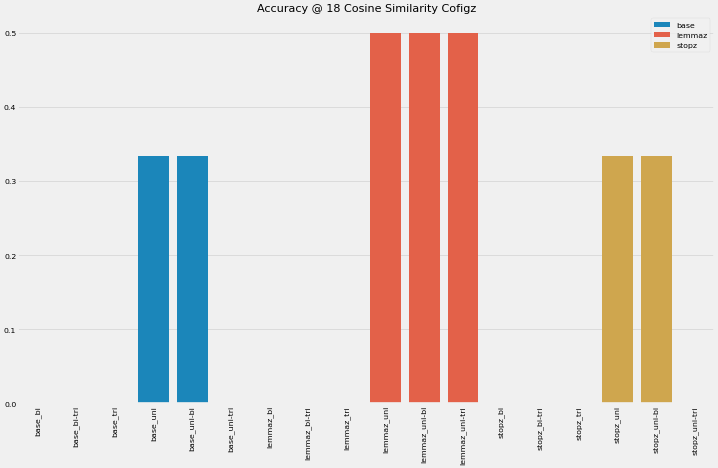

In [17]:
runFineTuneCosineHyperz()

## 4.2 Save to File

INFOR   : 2020-04-08 20:58:02.786788 [cosine.predict] IN: ['is corana deadly']
INFOR   : 2020-04-08 20:58:02.786788 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:02.787778 [cosine.predict] IN.CLEAN: ['is', 'corana', 'deadly']
INFOR   : 2020-04-08 20:58:02.788768 [cosine.predict] IN: ['what is corana']
INFOR   : 2020-04-08 20:58:02.788768 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': True, 'lemmatized': True, 'unique': False}}
INFOR   : 2020-04-08 20:58:02.789769 [cosine.predict] IN.CLEAN: ['what', 'is', 'corana']
INFOR   : 2020-04-08 20:58:02.790735 [cosine.predict] IN: ['should my pet get tested']
INFOR   : 2020-04-08 20:58:02.790735 [cosine.predict] IN.PREPROC: {'cleanup_and_lemmatize': {'remove_stopwordz': False, 'stop_wordz': None, 'remove_numberz': True, 'lemmatiz


------ 6. TUNE : Cheking different n-gram and cleaning combinations ------

------ 7. TUNE.RESULTS : Tabulate Results  ------
base_uni 		acc = 0.3333333333333333
stopz_uni 		acc = 0.3333333333333333

------------
KEY:
	>>base = keep text as is 
	>>lemmaz = remove stop words, numbers and lemmatize 
	>>stopz = keep stop words but remove numbers and lemmatize 
	>>uni, bi, tri = unigram, bigram, trigram respectively.
	 And so is the range E.g. uni-tri = (1,3)

------ 8. TUNE.RESULTS : Plot Results  ------


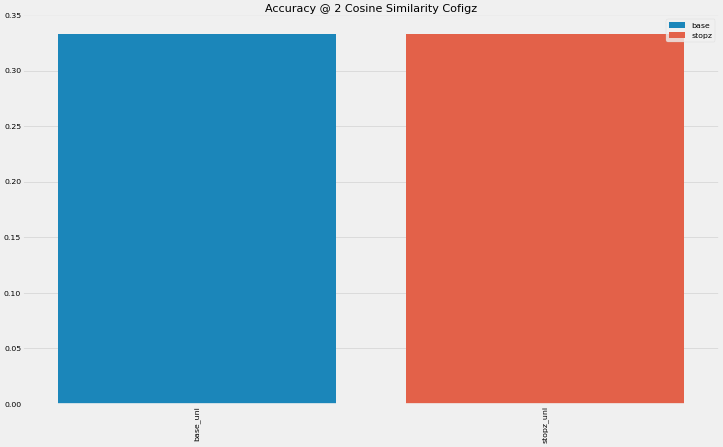

In [18]:
ftnamez = ['stopz_uni']
ftgramz = [(1,1)] 

runFineTuneCosineHyperz(tnamez=ftnamez, tgramz=ftgramz)

In [19]:
print( model )

<class 'zmodel_cosine_similarity.ZCosineSimilarity'> TFIDF_Cosine with model file 'TFIDF_Cosine'


In [20]:
model.dumpSave("cov_Cosine_Tfidf")

INFOR   : 2020-04-08 20:58:02.919391 [<class 'zmodel_cosine_similarity.ZCosineSimilarity'>.model.dump] Model saved to file successfully


# 5.1 Multi-class MLP 

In [21]:
##### Helper functions
## Plot graphs 
def plot_graphs(fhist, metric): 
    plt.plot(fhist[ metric ] )
    plt.plot( fhist['val_'+metric ] , '')
    plt.xlabel('Epochs')
    plt.ylabel( metric )
    plt.legend( [ metric, 'val_'+metric ] )
    plt.show()
    
def build_and_compile(build_paramz, i, log=True):
    if log:
        print("\n{0} {1}. BUILD model {0}".format("-"*6, i ))
    mlpNN.build( dset.context, 
                dset.encoded_matrix, 
                dset.ylabelzAsInts(), 
                dset.preprocessor, 
                **build_paramz )
    
    if log:
        print(" n_classes @ ylabz.size = {}".format( len(dset.ylabelzAsInts() ) ) ) 
        
    if log:
        print("{}".format( mlpNN.model.summary() ) ) 
        
    return i+1
    

def train_and_validate(train_paramz, i, log=True):
    if log:
        print("\n{0} {1}. TRAIN model{0}".format("-"*6, i ))
    val_x = dset.encodePredict(val_txt) 
    val_y = np.array(  val_ylabz_int )
    val_x_y_pair = (val_x,  val_y) 
    
    if log:
        print("val_encoded: {}, val_labelz: {}".format( val_x.shape, val_y.shape))
    
    train_hist = mlpNN.train( val_x_y_pair, **train_paramz)
    
    if log:
        print("FINISHED: Validation: Accuracy = {} Loss = {}".format(
            train_hist['val_acc'][-1], train_hist['val_loss'][-1]
            ))
    if log:
        plot_graphs(train_hist, 'acc' ) 
        
    return train_hist['val_acc'][-1], train_hist['val_loss'][-1], train_hist['acc'][-1]
    
    
def resetModel_and_validate(paramz, ngramz, build_paramz, train_paramz, log=True):
    i = 3
    resetData( paramz, ngramz, log)     
    i = build_and_compile(build_paramz, i, log)
    return train_and_validate(train_paramz, i, log)
    
    
def doBaseline(build_paramz, train_paramz, log=True):
    i = 1
    i = build_and_compile(build_paramz, i, log)
    return train_and_validate(train_paramz, i, log)
   

In [22]:
from zmodel_ngram_mlp import NgramMLP

In [23]:
mlpNN = NgramMLP('ngram_mlp')
epochz = 1000

In [24]:

## do baseline
build_paramz = {    
        'n_classez' : dset.getNumberClasses(), 
        'vocab_size' : len( dset.getVocab() ),
        't_ratio' : dset.thresholdRatio(), 
        'n_hidden_layerz' : 2, 
        'n_hidden_unitz' : 128, 
        'dropout_rate' : 0.2,
        'learning_rate' : 1e-3
}

## training paramz 
train_paramz = {
        'epochs' : epochz,
        'batch_size' : 128,} 



------ 9. MLP : Run baseline cofig ------

------ 1. BUILD model ------
 n_classes @ ylabz.size = 137
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 305)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               39168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 52)                6708      
Total params: 45,876
Trainable params: 45,876
Non-trainable params: 0
_________________________________________________________________
None

------ 2. TRAIN model------
val_encoded: (6, 305), val_labelz: (6,)


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.8.
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score

findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (courbi.ttf) italic 

findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) no

findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
findfont: score(<Font 'Calisto MT' (

findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 3.9713636363636367
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.8 to DejaVu Sans ('C:\\Users\\bilha\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


FINISHED: Validation: Accuracy = 0.8333333134651184 Loss = 1.0724936723709106


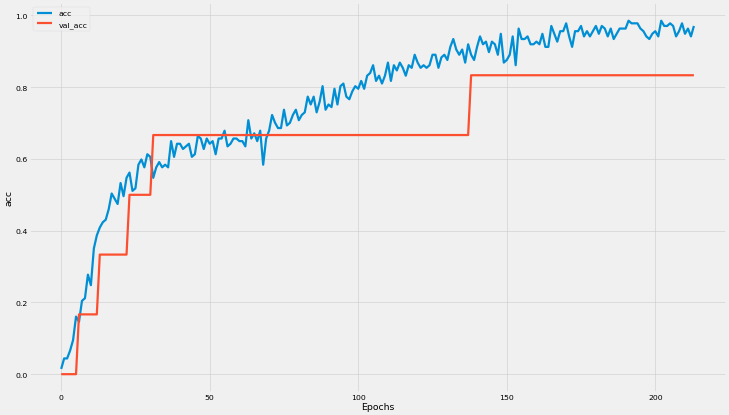

In [25]:
printHeadline('MLP', 'Run baseline cofig')

mlp_base_acc = doBaseline(build_paramz, train_paramz,)

In [26]:
def runFineTuneMLPHyperz(tnamez=tnamez, tgramz=tgramz, 
                         build_paramz = build_paramz, 
                         train_paramz = train_paramz,
                         base_acc = None, log=True):
    run_modez = {}
    if base_acc is not None:
        run_modez['base_uni'] = base_acc
        
    if log:
        printHeadline('TUNE', 'Cheking different n-gram and cleaning combinations')
    for tryz, tgram in zip(tnamez, tgramz):
        argzd = getParamz(tryz)
        acc = resetModel_and_validate( argzd, tgram, build_paramz, train_paramz, log=False)
        run_modez[tryz] = acc 
        
    if log:
        printHeadline('TUNE.RESULTS', "Tabulate Results (val_acc, val_loss, train_acc) ")
        for k, g in run_modez.items():
            print("{} \t\tacc = {}".format(k, g) ) 
            
        print("\n{0}\nKEY:{1}{2} {1}{3} {1}{4} {1}{5}".format( "-"*12, "\n\t>>", 
                "base = keep text as is",
                "lemmaz = remove stop words, numbers and lemmatize", 
                "stopz = keep stop words but remove numbers and lemmatize", 
                "uni, bi, tri = unigram, bigram, trigram respectively.\n\t And so is the range E.g. uni-tri = (1,3)") )
        
    return run_modez


def runTuneMLP_BaselineNGramz(tnamez=tnamez, tgramz=tgramz, 
                         build_paramz = build_paramz, 
                         train_paramz = train_paramz,
                         base_acc = mlp_base_acc, log=True):
    
    run_modez = runFineTuneMLPHyperz(tnamez, tgramz, build_paramz, train_paramz, base_acc , log)
    
    if log:
        printHeadline('TUNE.RESULTS', "Plot Results ")
        sorted_keyz = list(run_modez.keys() )
        sorted_keyz.sort() 
        sorted_valuez = [ run_modez[k][0] for k in sorted_keyz ] ## accuracy only for now : TODO: both loss and accuracy
        plotAcc(sorted_keyz, 
                sorted_valuez, 
                [x.split('_')[0] for x in sorted_keyz ], 
                "MLP NGramz - Baseline Accuracy")
 


------ 10. MLP.TUNE : Keep baseline model Config AND Tweak Vectorization ------

------ 11. TUNE : Cheking different n-gram and cleaning combinations ------

------ 12. TUNE.RESULTS : Tabulate Results (val_acc, val_loss, train_acc)  ------
base_uni 		acc = (0.8333333, 1.0724936723709106, 0.9708029)
lemmaz_uni 		acc = (1.0, 0.4174889624118805, 0.96350366)
stopz_uni 		acc = (0.8333333, 1.0560880899429321, 0.96350366)
base_bi 		acc = (0.5, 2.757641077041626, 0.99270076)
base_tri 		acc = (0.33333334, 3.309943914413452, 0.919708)
base_uni-bi 		acc = (0.6666667, 1.4306215047836304, 0.99270076)
base_uni-tri 		acc = (0.6666667, 1.815553069114685, 1.0)
base_bi-tri 		acc = (0.5, 2.6769754886627197, 0.99270076)
lemmaz_bi 		acc = (0.0, 3.6288022994995117, 0.71532845)
lemmaz_tri 		acc = (0.16666667, 3.651254415512085, 0.5985401)
lemmaz_uni-bi 		acc = (0.8333333, 1.3445266485214233, 0.99270076)
lemmaz_uni-tri 		acc = (0.6666667, 1.5577887296676636, 0.99270076)
lemmaz_bi-tri 		acc = (0.0, 3.63587307

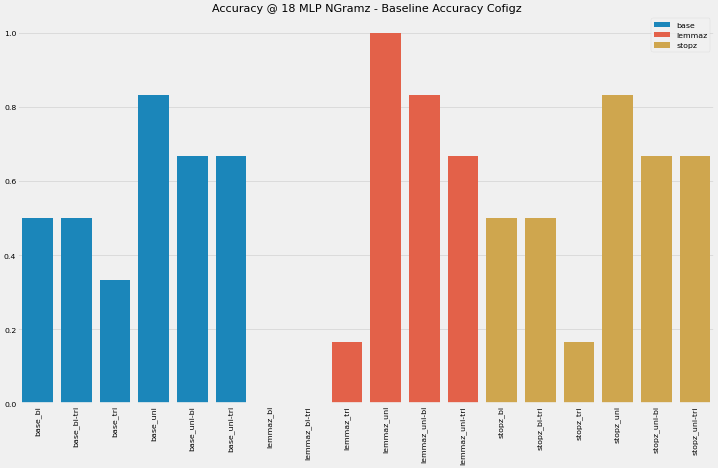

In [27]:
printHeadline('MLP.TUNE', 'Keep baseline model Config AND Tweak Vectorization' )
runTuneMLP_BaselineNGramz()

In [28]:
### ----- Keep Lemmatization from above and Tweak MLP congis now
printHeadline('MLP.TUNE', 'Tweak model Config AND Check at Lemmatized Vectorization' )

build_layerz = [1, 2, 3, 4, 6, 10, 15, 20, 24, 32, 64, 128, 256]
build_unitz = [ 1, 2, 4, 8, 16, 24, 32, 64, 128, 256]
build_dropratez = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
build_lrate = [1e-4, 1e-3, 1e-2, 1e-1]   

best_conf = {
    'n_layerz' : 0,
    'n_unitz' : 0,
    'r_dropout' : 0,
    'r_learning' : 0,
}

def getBuildParamz(n_layerz=0, n_unitz=0, 
                   r_dropout=0, r_learning=0):
    return {
        **build_paramz,
        **{          
            'n_hidden_layerz' : build_layerz[ n_layerz ], 
            'n_hidden_unitz' : build_unitz[ n_unitz ], 
            'dropout_rate' : build_dropratez[ r_dropout ],
            'learning_rate' : build_lrate[ r_learning]  
        } }



------ 14. MLP.TUNE : Tweak model Config AND Check at Lemmatized Vectorization ------


In [29]:
## Update after baseline run
other_paramz = {
    'tnamez' : ['lemmaz_uni', 'lemmaz_uni-bi', 'stopz_uni', 'base_uni-bi', 'base_uni-tri', 'base_uni'], 
    'tgramz' : [(1,1), (1,2), (1,1), (1,2), (1,3), (1,1)], 
    'train_paramz' : train_paramz, 
    'base_acc' : None, #mlp_base_acc
    'log' : False,
}


def runTuneMLP_BuildConfig(target_name, target_valz ):       
    all_modez = {}
    
    printHeadline("TUNE.MLP.MODEL", "Changing {}".format(target_name ) ) 
    
    ## 1. run for different vectorizations ngramz 
    for i in range(0, len(target_valz)-1 ) :
        modez = runFineTuneMLPHyperz( 
                    build_paramz =  getBuildParamz( **{ **best_conf, **{target_name : i}} ),  
                    **other_paramz )
        
        for k, v in modez.items():
            all_modez[ "{}_{}_{}".format(target_name, target_valz[i], k) ] = v 
    
    ## 2. tabulate results 
    printHeadline('TUNE.MPL.BUILD', "Tabulate Results (val_acc, val_loss, train_acc) ")
    for k, v in all_modez.items():
        print("{}\t\t\tacc = {}".format(k, v) )
        
    ## 3. plot results 
    printHeadline('TUNE.MLP.BUILD', "Plot Results @ {}".format(target_name) )
    sorted_keyz = list(all_modez.keys() )
    sorted_keyz.sort() 
    sorted_valuez = [ all_modez[k][0] for k in sorted_keyz ] ## accuracy only for now : TODO: both loss and accuracy
    plotAcc(sorted_keyz, 
            sorted_valuez, 
            [x.split('_')[2] for x in sorted_keyz ], 
            "MLP Accuracy - {}".format(target_name) ) 
    
    ## 4. get best accuracy config
    i_max_acc = np.array([ a[0] for a in all_modez.values() ] ).argmax()
    lbl_max_acc = list(all_modez.keys() )[i_max_acc]
    idx_max_acc = int( i_max_acc / len(other_paramz['tnamez']) )
    
    return idx_max_acc, lbl_max_acc


------ 15. TUNE.MLP.MODEL : Changing n_layerz ------

------ 16. TUNE.MPL.BUILD : Tabulate Results (val_acc, val_loss, train_acc)  ------
n_layerz_1_lemmaz_uni			acc = (0.33333334, 3.7343952655792236, 0.6569343)
n_layerz_1_lemmaz_uni-bi			acc = (0.6666667, 3.696960687637329, 0.84671533)
n_layerz_1_stopz_uni			acc = (0.6666667, 3.6054279804229736, 0.79562044)
n_layerz_1_base_uni-bi			acc = (0.6666667, 3.6153175830841064, 0.9489051)
n_layerz_1_base_uni-tri			acc = (0.6666667, 3.660684823989868, 1.0)
n_layerz_1_base_uni			acc = (0.6666667, 3.6355483531951904, 0.82481754)
n_layerz_2_lemmaz_uni			acc = (0.0, 3.8713462352752686, 0.04379562)
n_layerz_2_lemmaz_uni-bi			acc = (0.0, 3.8668315410614014, 0.0729927)
n_layerz_2_stopz_uni			acc = (0.16666667, 3.8912534713745117, 0.04379562)
n_layerz_2_base_uni-bi			acc = (0.16666667, 3.852100133895874, 0.08029197)
n_layerz_2_base_uni-tri			acc = (0.0, 3.935894250869751, 0.02189781)
n_layerz_2_base_uni			acc = (0.5, 3.8895435333251953, 0.04379562)
n_

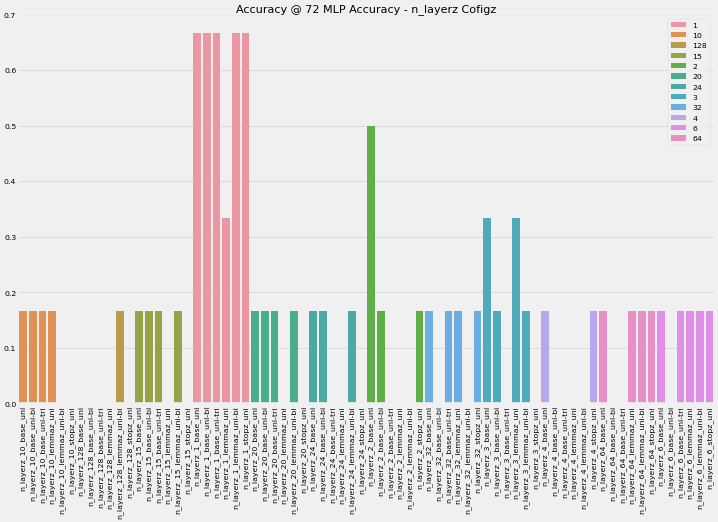

In [30]:
## 1. Layers ---- n_layerz=0, n_unitz=0, r_dropout=0, r_learning=0 
idx_best, lbl_best = runTuneMLP_BuildConfig('n_layerz', build_layerz )

0 n_layerz_1_lemmaz_uni-bi {'n_layerz': 0, 'n_unitz': 0, 'r_dropout': 0, 'r_learning': 0}

------ 18. TUNE.MLP.MODEL : Changing n_unitz ------

------ 19. TUNE.MPL.BUILD : Tabulate Results (val_acc, val_loss, train_acc)  ------
n_unitz_1_lemmaz_uni			acc = (0.5, 3.6776669025421143, 0.67153287)
n_unitz_1_lemmaz_uni-bi			acc = (0.33333334, 3.7104055881500244, 0.8978102)
n_unitz_1_stopz_uni			acc = (0.8333333, 3.6021623611450195, 0.8029197)
n_unitz_1_base_uni-bi			acc = (0.6666667, 3.605919599533081, 0.96350366)
n_unitz_1_base_uni-tri			acc = (0.6666667, 3.6285431385040283, 0.9781022)
n_unitz_1_base_uni			acc = (0.6666667, 3.600332498550415, 0.810219)
n_unitz_2_lemmaz_uni			acc = (0.6666667, 3.6330864429473877, 0.68613136)
n_unitz_2_lemmaz_uni-bi			acc = (0.5, 3.6961824893951416, 0.8978102)
n_unitz_2_stopz_uni			acc = (0.6666667, 3.624540328979492, 0.7810219)
n_unitz_2_base_uni-bi			acc = (0.8333333, 3.5968942642211914, 0.9708029)
n_unitz_2_base_uni-tri			acc = (0.8333333, 3.6442787647247

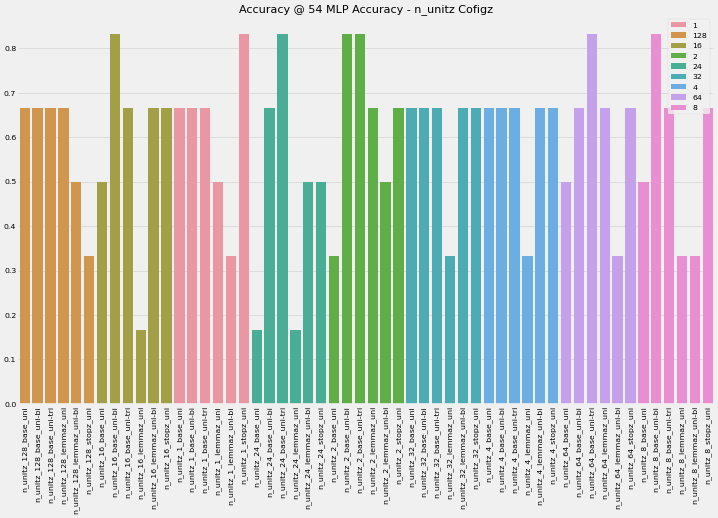

In [31]:
best_conf['n_layerz'] = idx_best ## from above
print(idx_best, lbl_best, best_conf)
idx_best, lbl_best = runTuneMLP_BuildConfig('n_unitz', build_unitz) 

0 n_unitz_1_stopz_uni {'n_layerz': 0, 'n_unitz': 0, 'r_dropout': 0, 'r_learning': 0}

------ 21. TUNE.MLP.MODEL : Changing r_dropout ------

------ 22. TUNE.MPL.BUILD : Tabulate Results (val_acc, val_loss, train_acc)  ------
r_dropout_0.1_lemmaz_uni			acc = (0.6666667, 3.628302574157715, 0.68613136)
r_dropout_0.1_lemmaz_uni-bi			acc = (0.6666667, 3.6326980590820312, 0.8613139)
r_dropout_0.1_stopz_uni			acc = (0.6666667, 3.627687454223633, 0.8394161)
r_dropout_0.1_base_uni-bi			acc = (0.8333333, 3.6293656826019287, 0.98540145)
r_dropout_0.1_base_uni-tri			acc = (0.6666667, 3.6085643768310547, 0.99270076)
r_dropout_0.1_base_uni			acc = (0.33333334, 3.68291974067688, 0.84671533)
r_dropout_0.2_lemmaz_uni			acc = (0.16666667, 3.719503402709961, 0.52554744)
r_dropout_0.2_lemmaz_uni-bi			acc = (0.33333334, 3.715651273727417, 0.8686131)
r_dropout_0.2_stopz_uni			acc = (0.6666667, 3.620854616165161, 0.7518248)
r_dropout_0.2_base_uni-bi			acc = (0.8333333, 3.6490581035614014, 0.9781022)
r_dropou

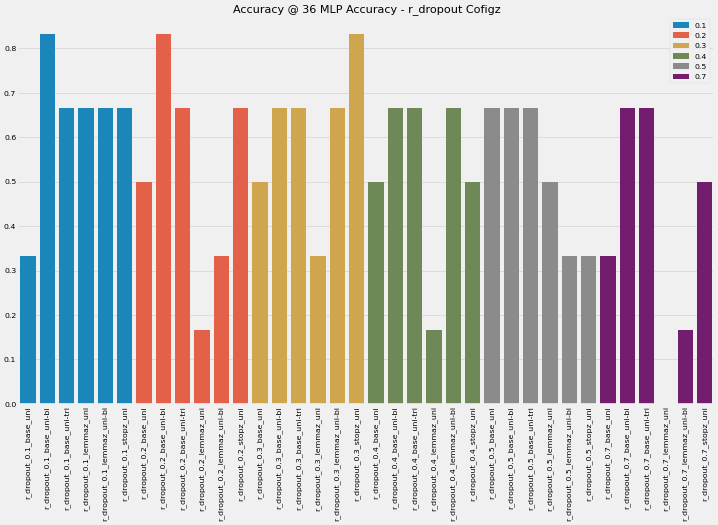

In [32]:
best_conf['n_unitz'] = idx_best ## from above
print(idx_best, lbl_best, best_conf)
idx_best, lbl_best = runTuneMLP_BuildConfig('r_dropout', build_dropratez)

0 r_dropout_0.1_base_uni-bi {'n_layerz': 0, 'n_unitz': 0, 'r_dropout': 0, 'r_learning': 0}

------ 24. TUNE.MLP.MODEL : Changing r_learning ------

------ 25. TUNE.MPL.BUILD : Tabulate Results (val_acc, val_loss, train_acc)  ------
r_learning_0.0001_lemmaz_uni			acc = (0.6666667, 3.696425676345825, 0.63503647)
r_learning_0.0001_lemmaz_uni-bi			acc = (0.6666667, 3.7163784503936768, 0.8686131)
r_learning_0.0001_stopz_uni			acc = (0.6666667, 3.6079695224761963, 0.79562044)
r_learning_0.0001_base_uni-bi			acc = (0.6666667, 3.6165409088134766, 0.9781022)
r_learning_0.0001_base_uni-tri			acc = (0.6666667, 3.5961577892303467, 0.99270076)
r_learning_0.0001_base_uni			acc = (0.6666667, 3.6439754962921143, 0.76642334)
r_learning_0.001_lemmaz_uni			acc = (0.8333333, 2.019362688064575, 0.94160587)
r_learning_0.001_lemmaz_uni-bi			acc = (0.6666667, 2.16731333732605, 0.99270076)
r_learning_0.001_stopz_uni			acc = (0.8333333, 1.7664333581924438, 0.9781022)
r_learning_0.001_base_uni-bi			acc = (0.6666

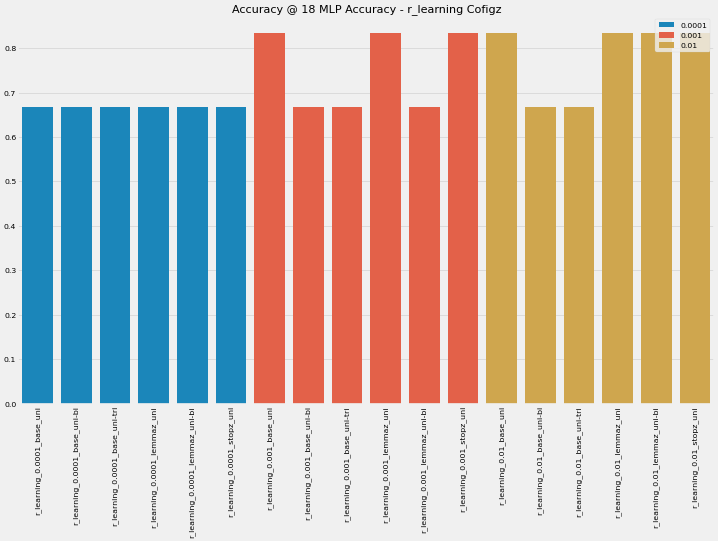

In [33]:
best_conf['r_dropout'] = idx_best ## from above
print(idx_best, lbl_best, best_conf)
idx_best, lbl_best = runTuneMLP_BuildConfig('r_learning', build_lrate )

In [34]:
## DEF @ custom combos given what we've learnt from above TODO: too lazy to combine with prior defs

def comboCheckMLP(build_config, lbl):       
    all_modez = {}

    printHeadline("TUNE.MLP.MODEL", " With Best @ {}".format( lbl) ) 
    # for k, v in best_conf.items():
    print( "CONFIG: {} = {}, {} = {}, {} = {}, {} = {}".format(
        'n_layerz', build_layerz[ best_conf['n_layerz']], 
        'n_unitz', build_unitz[ best_conf['n_unitz']], 
        'r_dropout', build_dropratez[ best_conf['r_dropout']], 
        'r_learning', build_lrate[ best_conf['r_learning']], 
    ) , end=" ") 
    print("")

    ## 1. run for different vectorizations ngramz 
    all_modez = runFineTuneMLPHyperz( build_paramz =  getBuildParamz( **build_config ) , **other_paramz )

    ## 2. tabulate results 
    printHeadline('TUNE.MPL.TRAINED', "Tabulate Results (val_acc, val_loss, train_acc) ")
    for k, v in all_modez.items():
        print("{} \t\tacc = {}".format(k, v) )

    ## 3. plot results 
    printHeadline('TUNE.MLP.ACC', "Plot Results @ Best {}".format( lbl ) )
    sorted_keyz = list(all_modez.keys() )
    sorted_keyz.sort() 
    sorted_valuez = [ all_modez[k][0] for k in sorted_keyz ] ## accuracy only for now : TODO: both loss and accuracy
    plotAcc(sorted_keyz, 
            sorted_valuez, 
            [x.split('_')[0] for x in sorted_keyz ], 
            "MLP Accuracy - {}".format( lbl) )

1 r_learning_0.001_lemmaz_uni {'n_layerz': 0, 'n_unitz': 0, 'r_dropout': 0, 'r_learning': 1}

------ 27. TUNE.MLP.MODEL :  With Best @ ALL from Above Steps ------
CONFIG: n_layerz = 1, n_unitz = 1, r_dropout = 0.1, r_learning = 0.001 

------ 28. TUNE.MPL.TRAINED : Tabulate Results (val_acc, val_loss, train_acc)  ------
lemmaz_uni 		acc = (0.8333333, 2.053339958190918, 0.94160587)
lemmaz_uni-bi 		acc = (0.6666667, 2.182887315750122, 1.0)
stopz_uni 		acc = (0.8333333, 1.7849239110946655, 0.98540145)
base_uni-bi 		acc = (0.6666667, 2.004923105239868, 1.0)
base_uni-tri 		acc = (0.6666667, 1.9898337125778198, 1.0)
base_uni 		acc = (0.8333333, 1.9449787139892578, 1.0)

------ 29. TUNE.MLP.ACC : Plot Results @ Best ALL from Above Steps ------


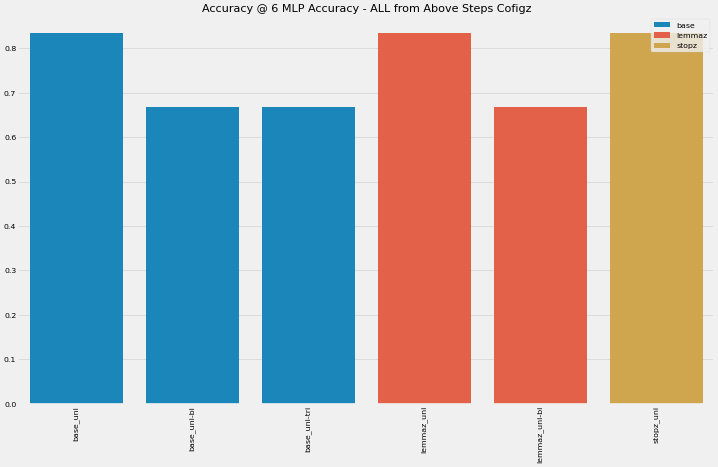

In [35]:
best_conf['r_learning'] = idx_best ## from above
print(idx_best, lbl_best, best_conf)

comboCheckMLP( best_conf, "ALL from Above Steps")


------ 30. TUNE.MLP.MODEL :  With Best @ V2.manual ------
CONFIG: n_layerz = 2, n_unitz = 32, r_dropout = 0.1, r_learning = 0.0001 

------ 31. TUNE.MPL.TRAINED : Tabulate Results (val_acc, val_loss, train_acc)  ------
lemmaz_uni 		acc = (0.33333334, 3.208953857421875, 0.37226278)
lemmaz_uni-bi 		acc = (0.33333334, 3.2316818237304688, 0.5985401)
stopz_uni 		acc = (0.6666667, 3.15376353263855, 0.5839416)
base_uni-bi 		acc = (0.6666667, 3.048569917678833, 0.8394161)
base_uni-tri 		acc = (0.5, 2.85058331489563, 0.8394161)
base_uni 		acc = (0.6666667, 3.0897254943847656, 0.5109489)

------ 32. TUNE.MLP.ACC : Plot Results @ Best V2.manual ------


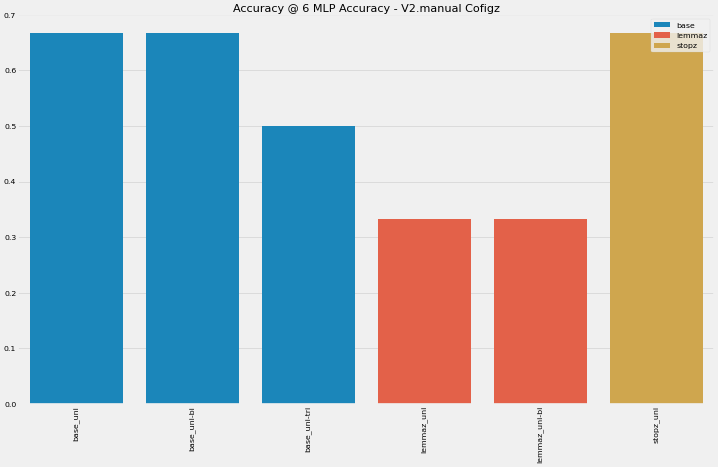

In [36]:
##### -- Try different combinations manually  ---- 
best_conf = {
    'n_layerz' : build_layerz.index( 2 ),
    'n_unitz' : build_unitz.index( 32 ),
    'r_dropout' : build_dropratez.index( 0.1) ,
    'r_learning' : build_lrate.index( 1e-4 ),
}

comboCheckMLP( best_conf, "V2.manual")


------ 33. TUNE.MLP.MODEL :  With Best @ V3.manual ------
CONFIG: n_layerz = 2, n_unitz = 64, r_dropout = 0.1, r_learning = 0.0001 

------ 34. TUNE.MPL.TRAINED : Tabulate Results (val_acc, val_loss, train_acc)  ------
lemmaz_uni 		acc = (0.6666667, 2.7080490589141846, 0.73722625)
lemmaz_uni-bi 		acc = (0.6666667, 2.6910617351531982, 0.82481754)
stopz_uni 		acc = (0.6666667, 2.4959957599639893, 0.74452555)
base_uni-bi 		acc = (0.6666667, 2.5122454166412354, 0.90510947)
base_uni-tri 		acc = (0.6666667, 2.5154287815093994, 0.98540145)
base_uni 		acc = (0.6666667, 2.5592405796051025, 0.68613136)

------ 35. TUNE.MLP.ACC : Plot Results @ Best V3.manual ------


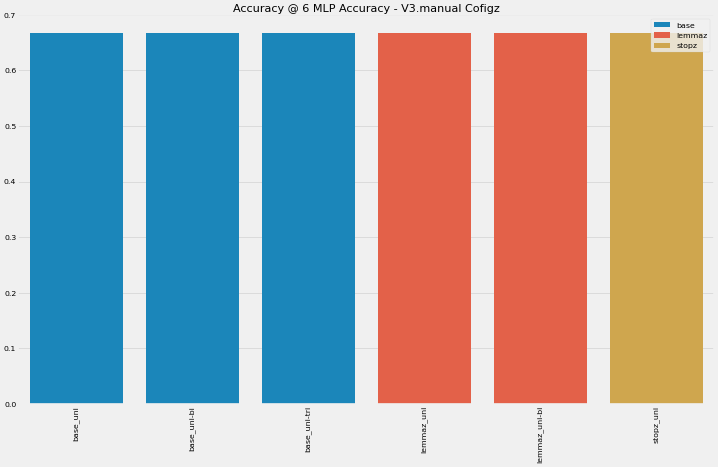

In [37]:
##### -- Try different combinations manually ---- 
best_conf = {
    'n_layerz' : build_layerz.index( 2 ),
    'n_unitz' : build_unitz.index( 64 ),
    'r_dropout' : build_dropratez.index( 0.1) ,
    'r_learning' : build_lrate.index( 1e-4 ),
}

comboCheckMLP( best_conf, "V3.manual")


------ 36. TUNE.MLP.MODEL :  With Best @ V4.manual ------
CONFIG: n_layerz = 2, n_unitz = 32, r_dropout = 0.5, r_learning = 0.0001 

------ 37. TUNE.MPL.TRAINED : Tabulate Results (val_acc, val_loss, train_acc)  ------
lemmaz_uni 		acc = (0.33333334, 3.5958750247955322, 0.1970803)
lemmaz_uni-bi 		acc = (0.33333334, 3.6008312702178955, 0.270073)
stopz_uni 		acc = (0.33333334, 3.470365524291992, 0.1970803)
base_uni-bi 		acc = (0.6666667, 3.3514020442962646, 0.4379562)
base_uni-tri 		acc = (0.5, 3.453094482421875, 0.42335767)
base_uni 		acc = (0.5, 3.493309259414673, 0.25547445)

------ 38. TUNE.MLP.ACC : Plot Results @ Best V4.manual ------


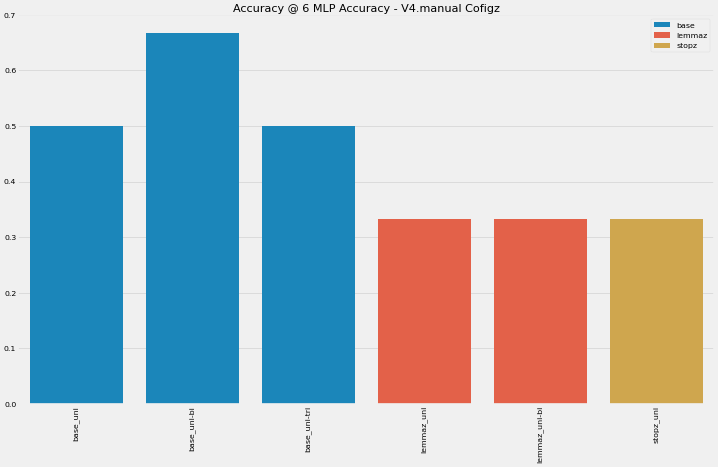

In [38]:
##### -- Try different combinations manually ---- 
best_conf = {
    'n_layerz' : build_layerz.index( 2 ),
    'n_unitz' : build_unitz.index( 32 ),
    'r_dropout' : build_dropratez.index( 0.5) ,
    'r_learning' : build_lrate.index( 1e-4 ),
}

comboCheckMLP( best_conf, "V4.manual")

In [39]:
#### TODO: more test cases

## 5.2. Save for Use


------ 39. TUNE.MLP.MODEL :  With Best @ V4.manual ------
CONFIG: n_layerz = 1, n_unitz = 4, r_dropout = 0.3, r_learning = 0.01 

------ 40. TUNE.MPL.TRAINED : Tabulate Results (val_acc, val_loss, train_acc)  ------
lemmaz_uni 		acc = (1.0, 1.2763043642044067, 0.84671533)

------ 41. TUNE.MLP.ACC : Plot Results @ Best V4.manual ------


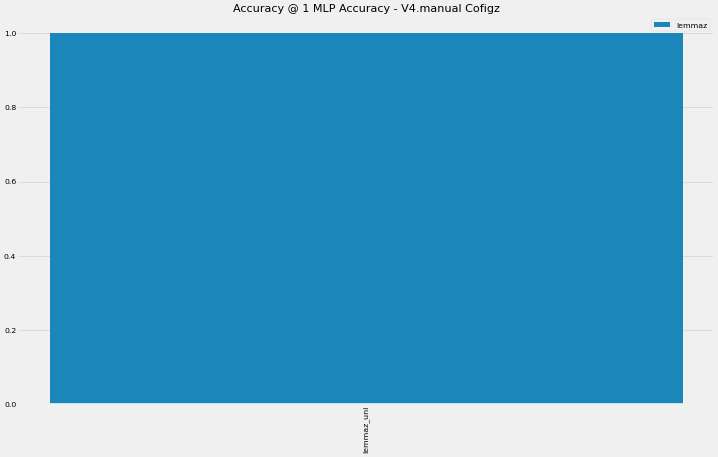

In [40]:
##### -- FINAL CONFIG ---- 
best_conf = {
    'n_layerz' : build_layerz.index( 1 ),
    'n_unitz' : build_unitz.index( 4 ),
    'r_dropout' : build_dropratez.index( 0.3 ) ,
    'r_learning' : build_lrate.index( 1e-2 ),
}

other_paramz = {
    'tnamez' : ['lemmaz_uni'], 
    'tgramz' : [(1,1)], 
    'train_paramz' : train_paramz, 
    'base_acc' : None, #mlp_base_acc
    'log' : False,
}


comboCheckMLP( best_conf, "V4.manual")

In [41]:
mlpNN.model.summary()

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2040 (Dropout)       (None, 244)               0         
_________________________________________________________________
dense_2040 (Dense)           (None, 52)                12740     
Total params: 12,740
Trainable params: 12,740
Non-trainable params: 0
_________________________________________________________________


In [42]:
mlpNN.dumpSave("cov_mlpNN_real")

INFOR   : 2020-04-08 21:29:27.775682 [<class 'zmodel_ngram_mlp.NgramMLP'>.model.dump] Model saved to file successfully
